In [ ]:
# Install all required libraries
!pip install numpy
!pip install matplotlib
!pip install --upgrade tensorflow-gpu

In [1]:
# Import the required libraries
import numpy as np
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

%matplotlib inline

In [2]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
# We will add noise to imitate real world examples
x_train_noisy = x_train + np.random.rand(60000, 784) * 0.6
x_test_noisy = x_test + np.random.rand(10000, 784) * 0.6

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

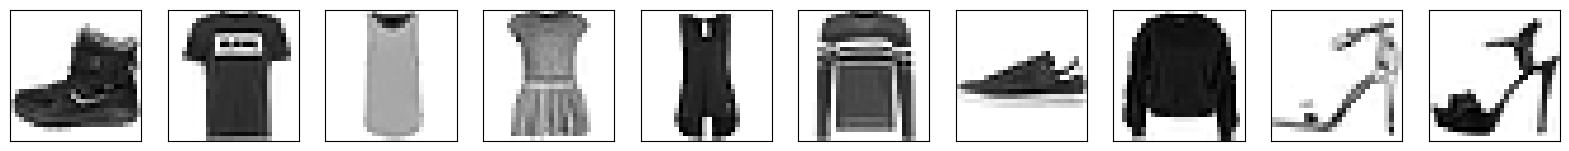

In [4]:
# Function to visualize the images
def plot(x, p, labels = False):
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i].reshape(28,28), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i]))
    plt.show()
    return
plot(x_train, None)

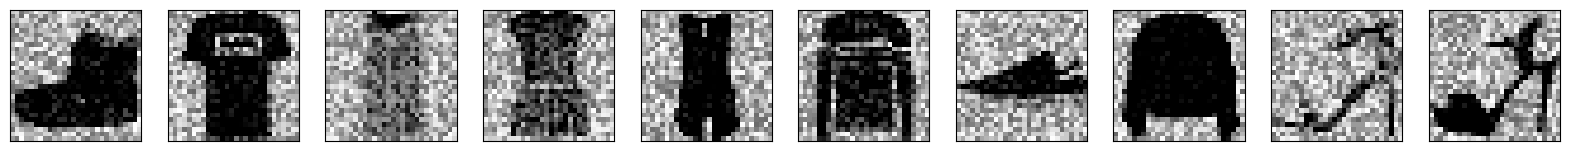

In [5]:
plot(x_train_noisy, None)

In [7]:
# Build a classifier trained on cleaned images
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.fit(x_train, y_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 3s 4ms/step - loss: 0.5067 - accuracy: 0.8215
Epoch 2/30
469/469 [==============================] - 1s 3ms/step - loss: 0.3663 - accuracy: 0.8669
Epoch 3/30
469/469 [==============================] - 1s 3ms/step - loss: 0.3236 - accuracy: 0.8806
Epoch 4/30
469/469 [==============================] - 2s 3ms/step - loss: 0.3035 - accuracy: 0.8871
Epoch 5/30
469/469 [==============================] - 1s 3ms/step - loss: 0.2818 - accuracy: 0.8954
Epoch 6/30
469/469 [==============================] - 2s 3ms/step - loss: 0.2656 - accuracy: 0.9006
Epoch 7/30
469/469 [==============================] - 1s 3ms/step - loss: 0.2552 - accuracy: 0.9047
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - loss: 0.2420 - accuracy: 0.9086
Epoch 9/30
469/469 [==============================] - 2s 4ms/step - loss: 0.2341 - accuracy: 0.9118
Epoch 10/30
469/469 [==============================] - 1s 3ms/step - loss: 0.2224 - accuracy: 0.9142

In [15]:
# Evaluate the model on clean test set
loss, acc = classifier.evaluate(x_test, y_test)
print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.4213 - accuracy: 0.8953
0.8952999711036682


In [9]:
# Evaluate the model on noisy test set
#x_test_noisy = np.array(x_test_noisy)
loss, acc = classifier.evaluate(x_test_noisy, y_test)
print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 8.9676 - accuracy: 0.2754
0.2754000127315521


In [ ]:
# We see that the model tests bad on the noisy test set so we now build an autoencoder model

In [13]:
# Building the encoder model
input_image = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_image)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

In [14]:
# Training the encoder model and stopping when the loss is same for 5 epochs
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=100, batch_size=128,
    validation_split=0.2, verbose=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
    ]
)

print(' _ ')
print('Training is complete!')

Epoch 1/100
375/375 [==============================] - 3s 5ms/step - loss: 0.3779 - val_loss: 0.3274
Epoch 2/100
375/375 [==============================] - 1s 4ms/step - loss: 0.3187 - val_loss: 0.3148
Epoch 3/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3101 - val_loss: 0.3085
Epoch 4/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3045 - val_loss: 0.3041
Epoch 5/100
375/375 [==============================] - 1s 3ms/step - loss: 0.3004 - val_loss: 0.3002
Epoch 6/100
375/375 [==============================] - 1s 4ms/step - loss: 0.2973 - val_loss: 0.2978
Epoch 7/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2949 - val_loss: 0.2958
Epoch 8/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2933 - val_loss: 0.2943
Epoch 9/100
375/375 [==============================] - 1s 3ms/step - loss: 0.2921 - val_loss: 0.2934
Epoch 10/100
375/375 [==============================] - 1s 4ms/step - loss: 0.2912 - val_lo

In [16]:
preds = autoencoder.predict(x_test_noisy)

313/313 [==============================] - 1s 2ms/step


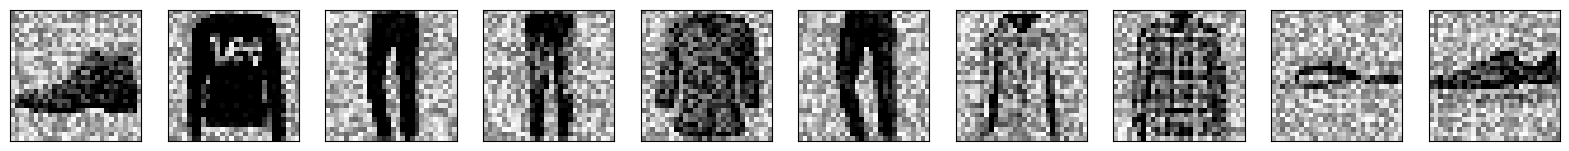

In [17]:
plot(x_test_noisy, None)

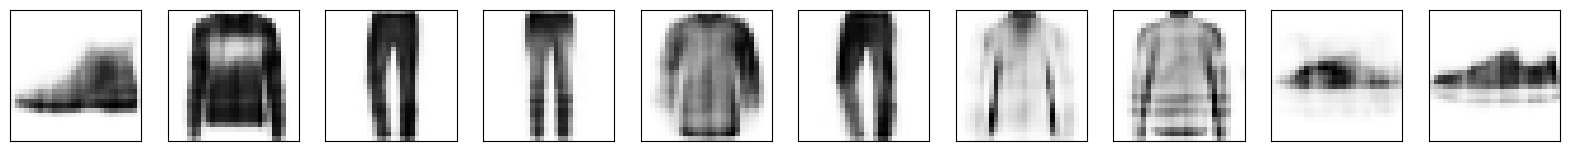

In [18]:
plot(preds, None)

In [19]:
# Now let's see our accuracy
loss, acc = classifier.evaluate(preds, y_test)
print(acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.6954 - accuracy: 0.8337
0.8337000012397766


In [20]:
# Building the composite model (The classifier and encoder in one model)
noisy_image = Input(shape=(784,))
x = autoencoder(noisy_image)
y = classifier(x)

denoise_and_classify = Model(noisy_image, y)

In [21]:
p = denoise_and_classify.predict(x_test_noisy)

313/313 [==============================] - 0s 1ms/step


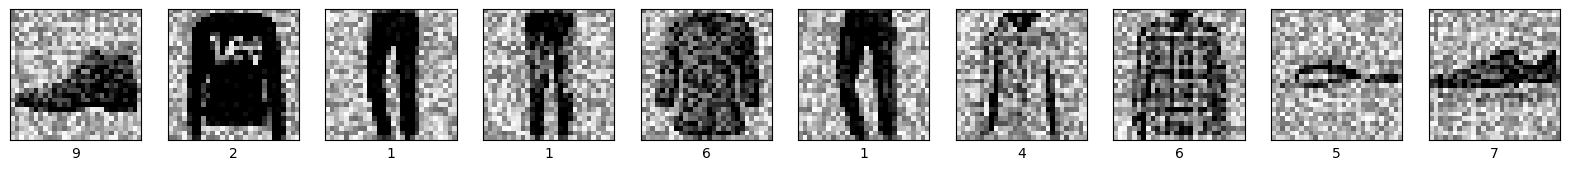

In [22]:
plot(x_test_noisy, p, True)

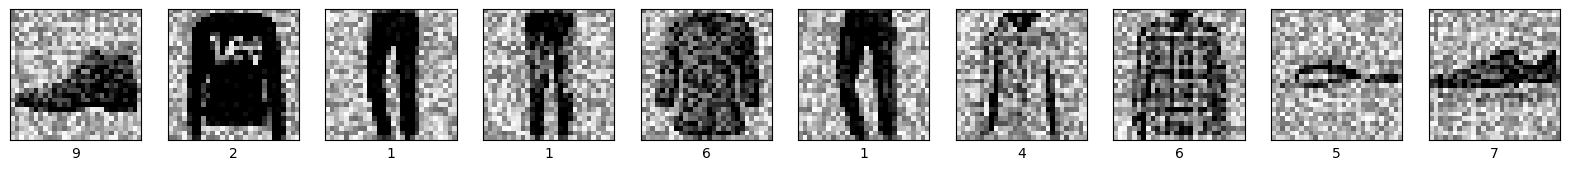

In [23]:
plot(x_test_noisy, to_categorical(y_test), True)

In [24]:
denoise_and_classify.save_weights('Final_weights.h5')

denoise_and_classify.save('model.h5')